In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import centroid

from psf_fit_utils import *

from tifffile import imread

In [2]:
# img = imread('20221114_PSF_Stellaris5_60X_1.tif')

# spacing = np.array([200, 36, 36])

In [3]:
img = imread('W1_Levi_40x_1_Conf488.stk')

# img = (img - img.min())/(img.max() - img.min()) * 1000

# img += 1000

# img = np.random.poisson(img) + np.random.normal(0, 100, size=img.shape)

spacing = np.array([200, 163, 163])

In [4]:
# img = imread('W1_Levi_63x_1_Conf488.stk')

# spacing = np.array([200, 103, 103])

In [5]:
# img = imread('XY266_Z622_simulated.tif')
# img = np.random.poisson(img*500) # Add some noise

# spacing = np.array([100, 40, 40])

In [6]:
psf = get_raw_crop(img, 4000, spacing)

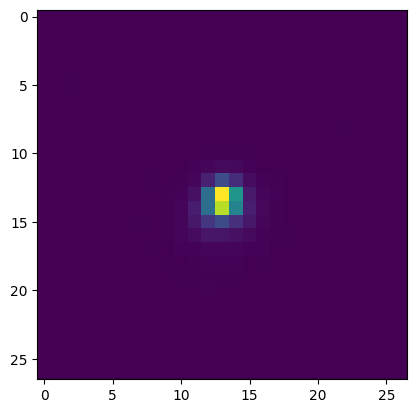

In [7]:
plt.imshow(psf[psf.shape[0]//2])

In [8]:
y_lim = [0, psf.max() * 1.1]

# 1D fits

## X

In [9]:
psf_x = psf[psf.shape[0]//2, psf.shape[1]//2]

In [10]:
coords_x = np.arange(len(psf_x)) * spacing[2]

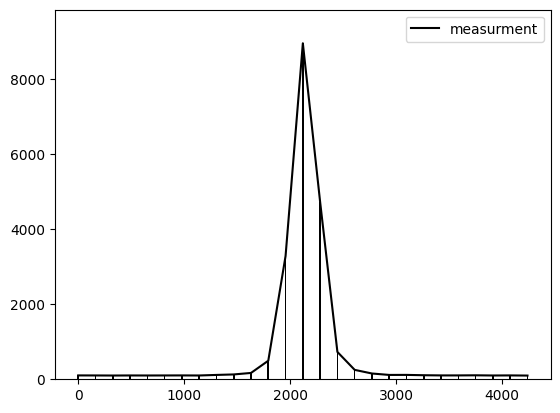

In [11]:
plt.plot(coords_x, psf_x, '-', label='measurment', color='k')
plt.bar(coords_x, psf_x, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [12]:
# bg = np.median(psf_x)
bg = np.median(psf)
amp = psf_x.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_x - bg, 0, psf_x.max()), [spacing[2]]))
mu = centroid(psf_x) * spacing[2]

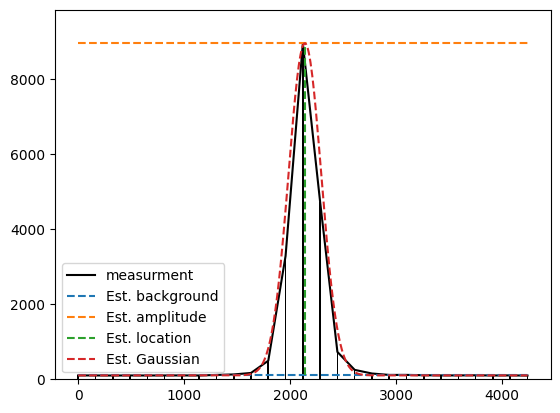

In [13]:
plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [14]:
from scipy.optimize import curve_fit

In [15]:
params = [amp, bg, mu[0], sigma]

In [16]:
popt, pcov = curve_fit(
    eval_fun,
    coords_x,
    psf_x,
    p0=params,
)

In [17]:
popt

array([8895.77883967,  126.4940292 , 2137.33092948,  127.03573616])

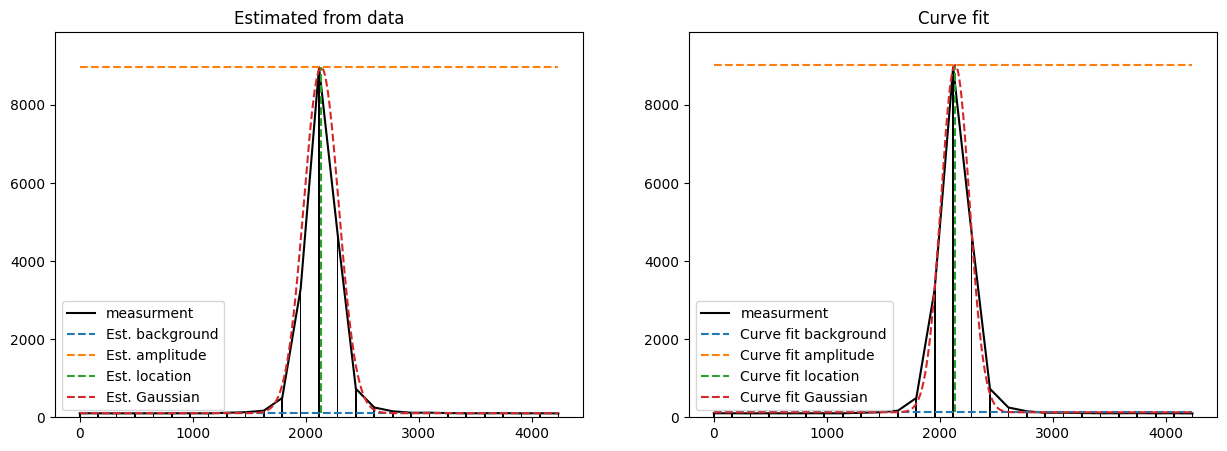

In [18]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_x, coords_x, params, "Est.", y_lim)
plt.title('Estimated from data');
plt.subplot(1,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [19]:
from scipy.special import kl_div
from scipy.optimize import minimize

In [20]:
res = compute_KL_div_fit(coords_x, psf_x, params, spacing)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94807D+03    |proj g|=  6.65828D+01

At iterate    1    f=  9.35517D+02    |proj g|=  1.49083D+01

At iterate    2    f=  5.04556D+02    |proj g|=  1.16063D+01

At iterate    3    f=  1.98958D+02    |proj g|=  4.75974D+00

At iterate    4    f=  1.70146D+02    |proj g|=  3.39627D+00

At iterate    5    f=  1.66680D+02    |proj g|=  1.63280D+00

At iterate    6    f=  1.63317D+02    |proj g|=  2.55753D-01

At iterate    7    f=  1.63239D+02    |proj g|=  7.91866D-02

At iterate    8    f=  1.63233D+02    |proj g|=  4.58434D-02

At iterate    9    f=  1.63229D+02    |proj g|=  4.55109D-02

At iterate   10    f=  1.63211D+02    |proj g|=  1.23937D-01

At iterate   11    f=  1.63167D+02    |proj g|=  2.68571D-01

At iterate   12    f=  1.63062D+02    |proj g|=  4.70992D-01

At iterate   13    f=  1.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


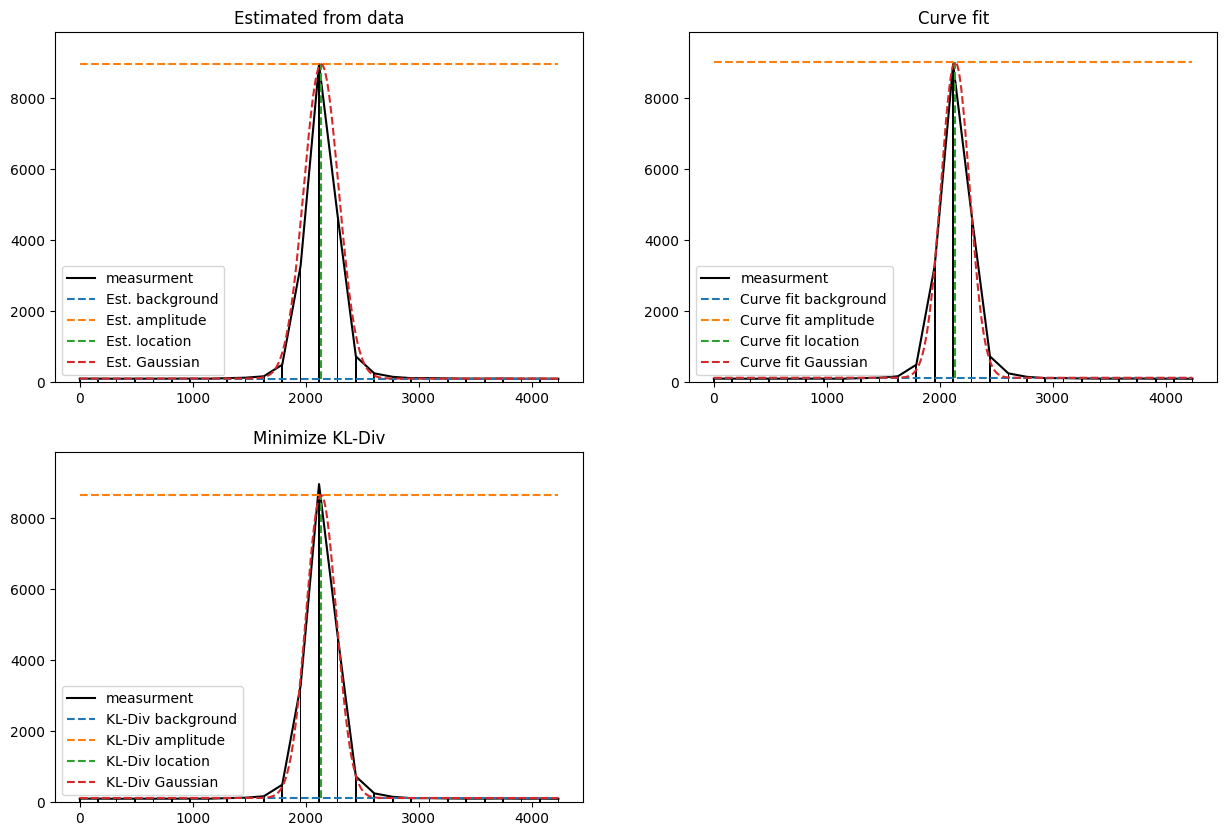

In [21]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_x, coords_x, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [22]:
est_fwhm_x = fwhm(sigma)
cv_fwhm_x = fwhm(popt[3])
kld_fwhm_x = fwhm(res.x[3])

In [23]:
mu_x = res.x[2]
amp_x = res.x[0]
bg_x = res.x[1]

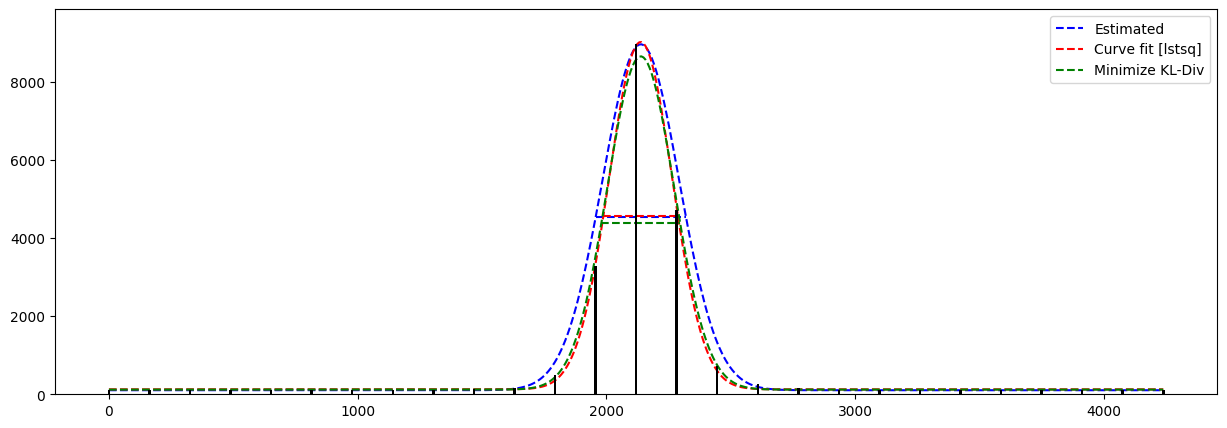

In [24]:
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_x, psf_x, width=10, color='k', zorder=10)
plt.plot(fine_coords_x, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_x), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_x / 2, mu[0] + est_fwhm_x / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_x, gauss_1d(*popt)(fine_coords_x), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_x / 2, popt[2] + cv_fwhm_x / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_x, gauss_1d(*res.x)(fine_coords_x), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_x / 2, res.x[2] + kld_fwhm_x / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [25]:
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

Estimated FWHM: 363.2114
Curve fit FWHM: 299.1463
Min. KL-D FWHM: 316.4547


In [26]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mse(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_x, psf_x):.3f}")

Mean Squared Error
Estimated: 119158.837
Curve fit: 2498.830
Min. KL-D: 10184.593


In [27]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mae(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_x, psf_x):.3f}")

Mean Absolute Error
Estimated: 132.105
Curve fit: 36.220
Min. KL-D: 50.769


In [28]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_x, psf_x, get_objective_1d):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_x, psf_x, get_objective_1d):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_x, psf_x, get_objective_1d):.3f}")

Kullback-Leibler Divergence
Estimated: 640.682
Curve fit: 116.116
Min. KL-D: 87.097


## Y

In [29]:
psf_y = psf[psf.shape[0]//2, :, psf.shape[2]//2]

In [30]:
coords_y = np.arange(len(psf_y)) * spacing[1]

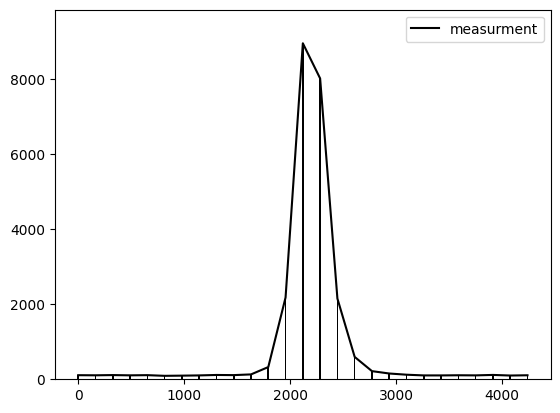

In [31]:
plt.plot(coords_y, psf_y, '-', label='measurment', color='k')
plt.bar(coords_y, psf_y, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [32]:
# bg = np.median(psf_y)
bg = np.median(psf)
amp = psf_y.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_y - bg, 0, psf_y.max()), [spacing[1]]))
mu = centroid(psf_y) * spacing[1]

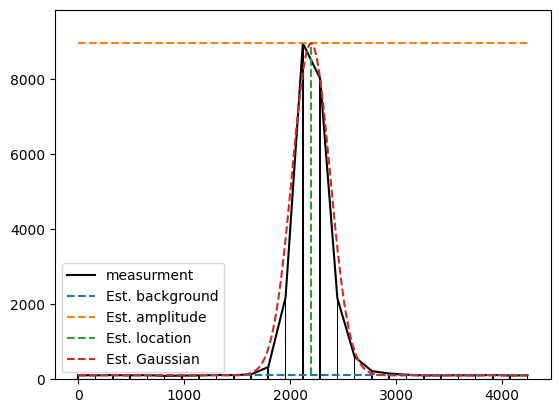

In [33]:
plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [34]:
params = [amp, bg, mu[0], sigma]

In [35]:
popt, pcov = curve_fit(
    eval_fun,
    coords_y,
    psf_y,
    p0=params,
)

In [36]:
popt

array([9990.53208713,  133.83819944, 2192.0570529 ,  137.0414644 ])

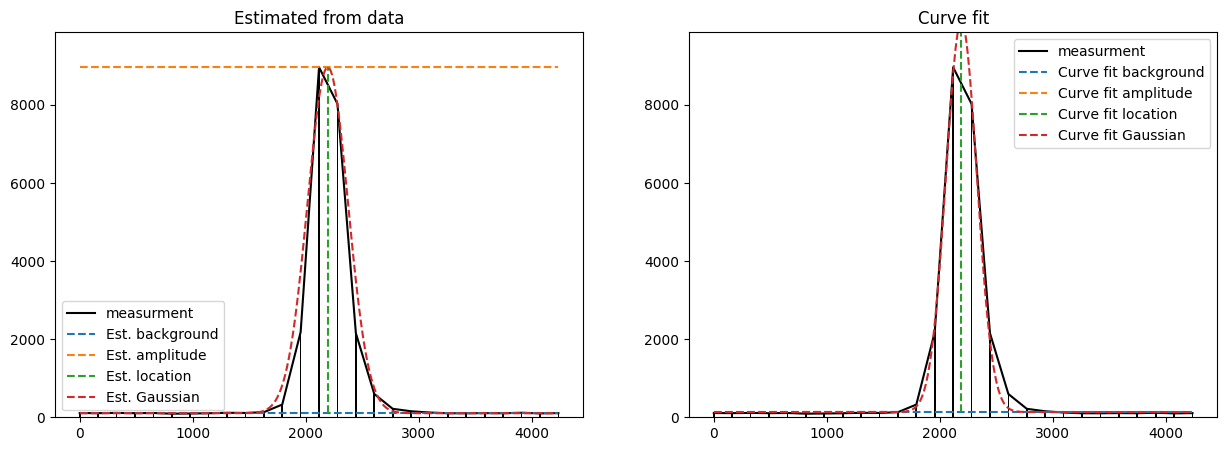

In [37]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_y, coords_y, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [38]:
res = compute_KL_div_fit(coords_y, psf_y, params, spacing)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07915D+03    |proj g|=  8.19824D+01

At iterate    1    f=  2.03276D+03    |proj g|=  3.10540D+01

At iterate    2    f=  4.02082D+02    |proj g|=  1.51801D+01

At iterate    3    f=  3.63254D+02    |proj g|=  7.74402D+00

At iterate    4    f=  3.49342D+02    |proj g|=  4.73042D+00

At iterate    5    f=  3.43333D+02    |proj g|=  2.84280D-01

At iterate    6    f=  3.43289D+02    |proj g|=  9.75639D-02

At iterate    7    f=  3.43278D+02    |proj g|=  9.74729D-02

At iterate    8    f=  3.43256D+02    |proj g|=  9.73650D-02

At iterate    9    f=  3.43202D+02    |proj g|=  2.34311D-01

At iterate   10    f=  3.43055D+02    |proj g|=  4.83947D-01

At iterate   11    f=  3.42677D+02    |proj g|=  8.80582D-01

At iterate   12    f=  3.41728D+02    |proj g|=  1.48397D+00

At iterate   13    f=  3.3

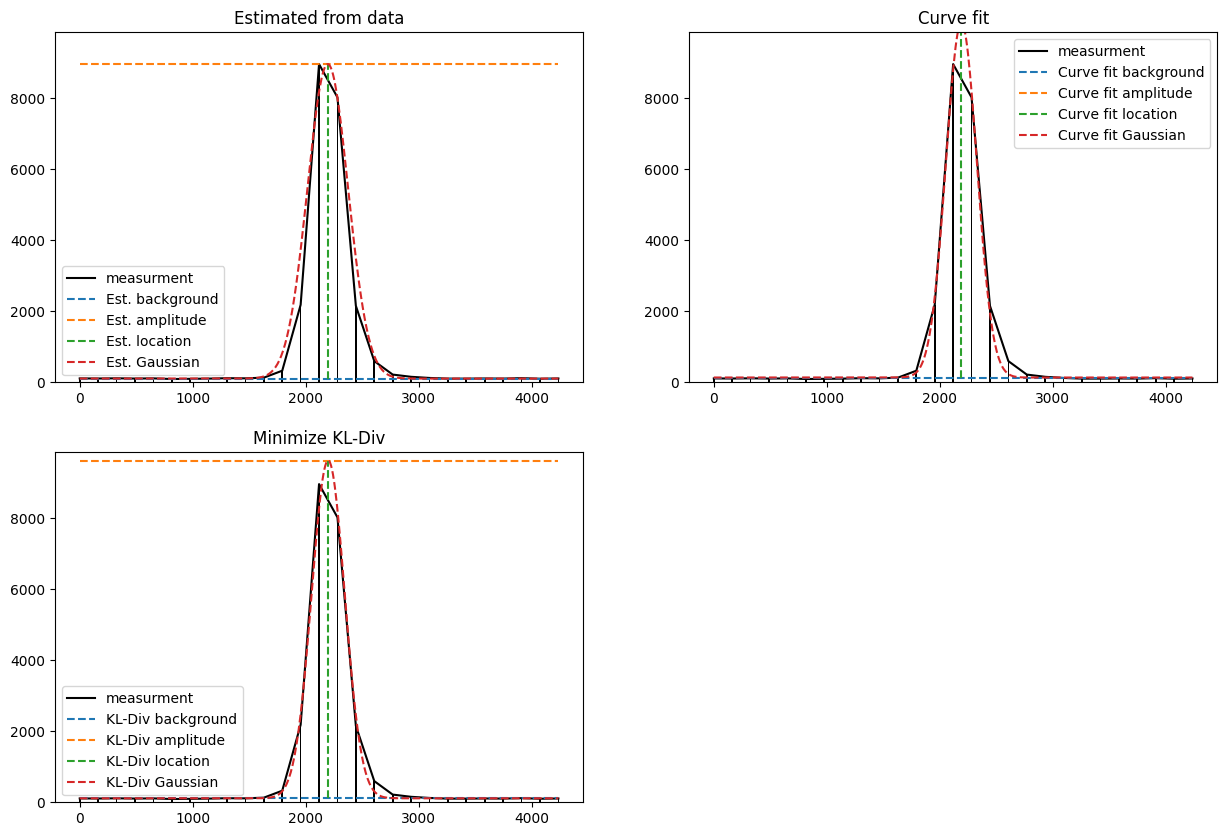

In [39]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_y, coords_y, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [40]:
est_fwhm_y = fwhm(sigma)
cv_fwhm_y = fwhm(popt[3])
kld_fwhm_y = fwhm(res.x[3])

In [41]:
mu_y = res.x[2]
amp_y = res.x[0]
bg_y = res.x[1]

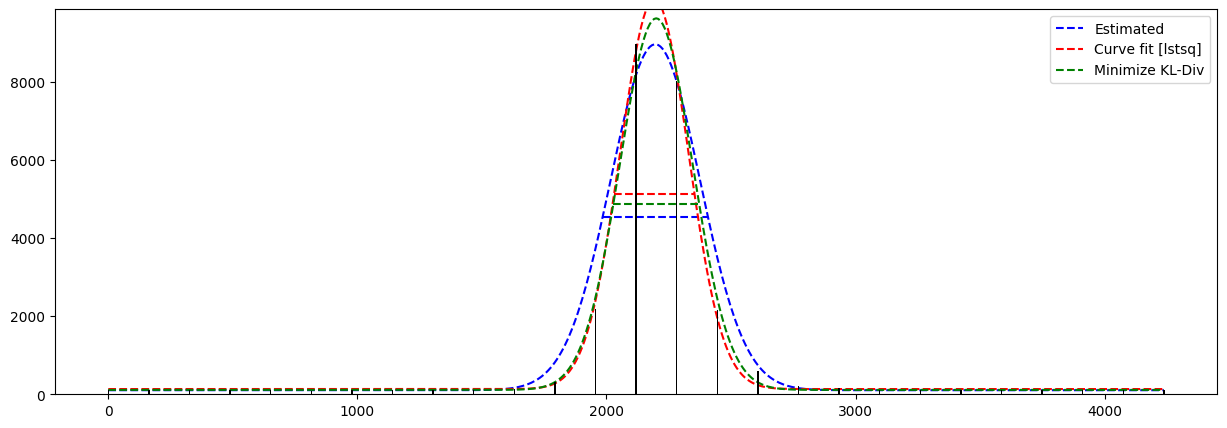

In [42]:
fine_coords_y = np.linspace(coords_y[0], coords_y[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_y, psf_y, width=5, color='k', zorder=10)
plt.plot(fine_coords_y, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_y), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_y / 2, mu[0] + est_fwhm_y / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_y, gauss_1d(*popt)(fine_coords_y), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_y / 2, popt[2] + cv_fwhm_y / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_y, gauss_1d(*res.x)(fine_coords_y), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_y / 2, res.x[2] + kld_fwhm_y / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [43]:
print("X")
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

X
Estimated FWHM: 363.2114
Curve fit FWHM: 299.1463
Min. KL-D FWHM: 316.4547


In [44]:
print("Y")
print(f"Estimated FWHM: {est_fwhm_y:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_y:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_y:.4f}")

Y
Estimated FWHM: 423.1665
Curve fit FWHM: 322.7080
Min. KL-D FWHM: 344.4842


In [45]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 188759.915
Curve fit: 10941.559
Min. KL-D: 29134.604


In [46]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 169.616
Curve fit: 64.796
Min. KL-D: 77.205


In [47]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y, get_objective_1d):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y, get_objective_1d):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y, get_objective_1d):.3f}")

Kullback-Leibler Divergence
Estimated: 1147.190
Curve fit: 252.100
Min. KL-D: 196.396


## Z

In [48]:
psf_z = psf[:, psf.shape[1]//2, psf.shape[2]//2]

In [49]:
coords_z = np.arange(len(psf_z)) * spacing[0]

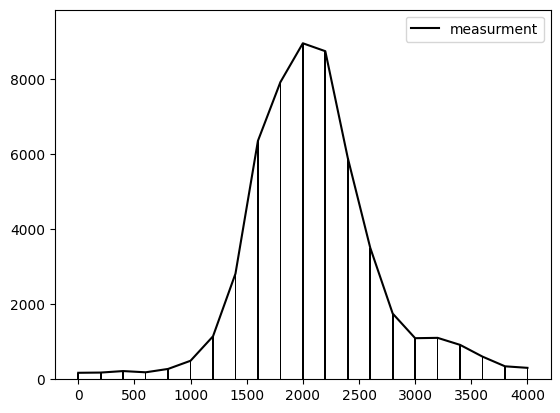

In [50]:
plt.plot(coords_z, psf_z, '-', label='measurment', color='k')
plt.bar(coords_z, psf_z, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [51]:
# bg = np.median(psf_z)
bg = np.median(psf)
amp = psf_z.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_z - bg, 0, psf_z.max()), [spacing[0]]))
mu = centroid(psf_z) * spacing[0]

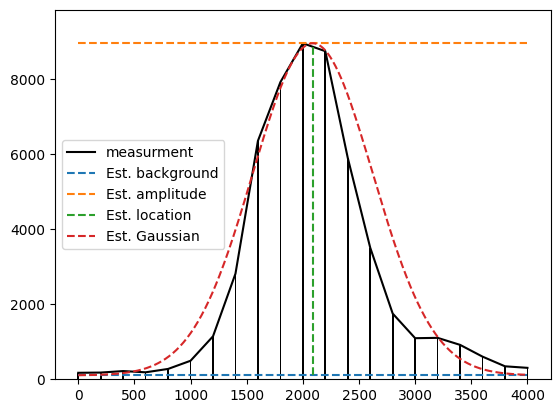

In [52]:
plot_fit_1d(psf_z, coords_z, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [53]:
params = [amp, bg, mu[0], sigma]

In [54]:
popt, pcov = curve_fit(
    eval_fun,
    coords_z,
    psf_z,
    p0=params,
)

In [55]:
popt

array([8922.66939192,  370.560491  , 2017.80701566,  404.63749088])

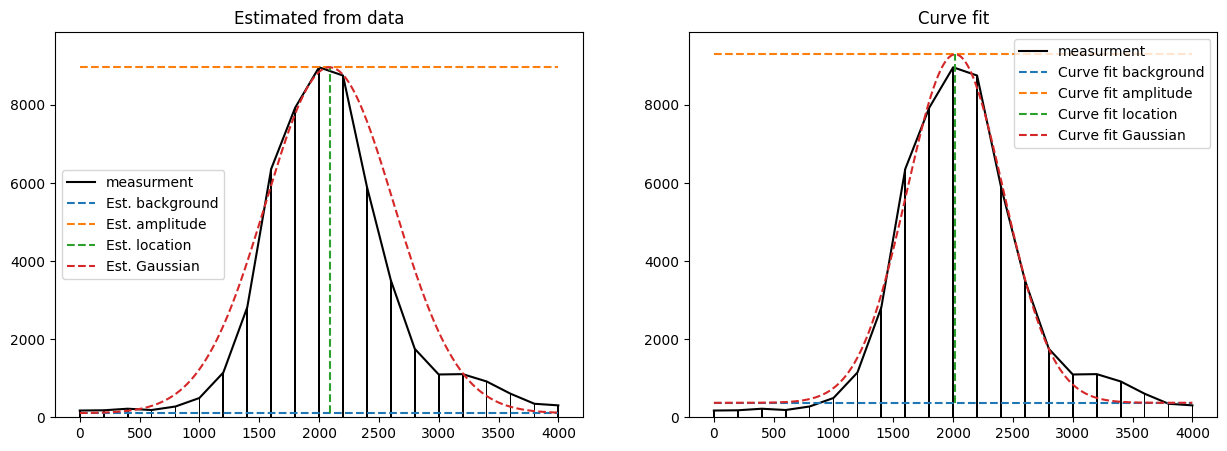

In [56]:
fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [57]:
res = compute_KL_div_fit(coords_z, psf_z, params, spacing)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53127D+03    |proj g|=  5.60374D+01

At iterate    1    f=  2.17525D+03    |proj g|=  2.66228D+01

At iterate    2    f=  1.37297D+03    |proj g|=  5.17722D+00

At iterate    3    f=  1.30451D+03    |proj g|=  3.71442D+00

At iterate    4    f=  1.20303D+03    |proj g|=  1.78072D+00

At iterate    5    f=  1.17738D+03    |proj g|=  8.36721D-01

At iterate    6    f=  1.17162D+03    |proj g|=  1.62572D-01

At iterate    7    f=  1.17154D+03    |proj g|=  1.77337D-02

At iterate    8    f=  1.17154D+03    |proj g|=  1.79611D-02

At iterate    9    f=  1.17153D+03    |proj g|=  1.80520D-02

At iterate   10    f=  1.17152D+03    |proj g|=  3.27873D-02

At iterate   11    f=  1.17147D+03    |proj g|=  6.95308D-02

At iterate   12    f=  1.17139D+03    |proj g|=  1.17461D-01

At iterate   13    f=  1.1

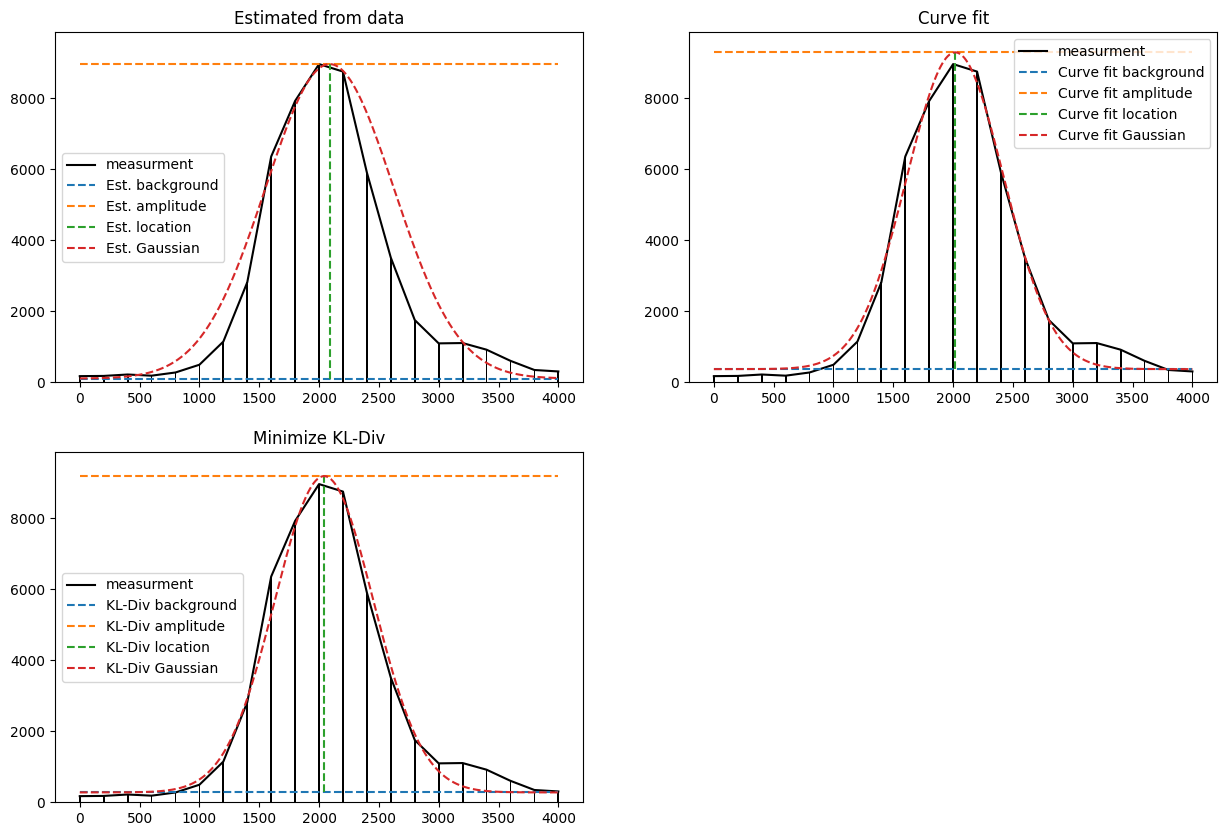

In [58]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_z, coords_z, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [59]:
est_fwhm_z = fwhm(sigma)
cv_fwhm_z = fwhm(popt[3])
kld_fwhm_z = fwhm(res.x[3])

In [60]:
mu_z = res.x[2]
amp_z = res.x[0]
bg_z = res.x[1]

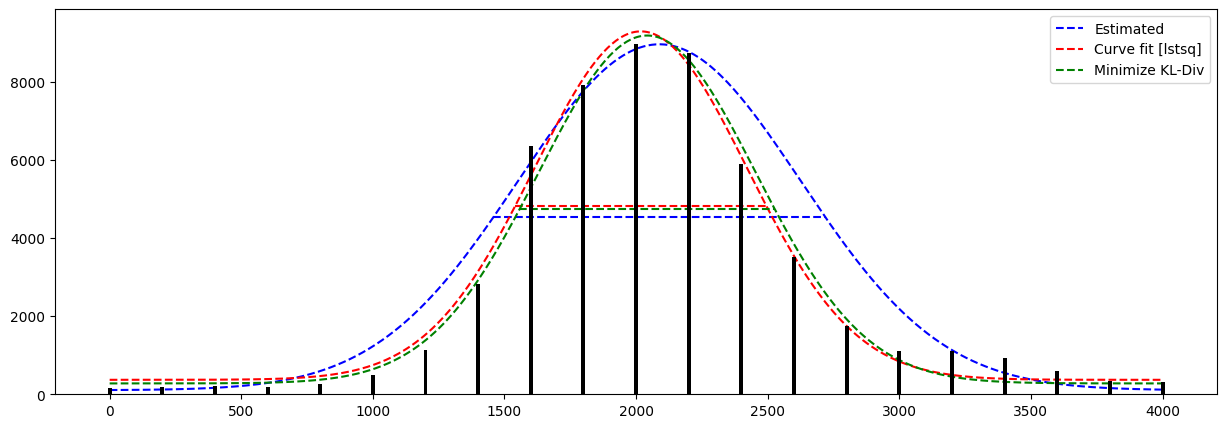

In [61]:
plt.figure(figsize=(15,5))
fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.bar(coords_z, psf_z, width=15, color='k', zorder=10)

plt.plot(fine_coords_z, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_z), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_z / 2, mu[0] + est_fwhm_z / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_z, gauss_1d(*popt)(fine_coords_z), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_z / 2, popt[2] + cv_fwhm_z / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_z, gauss_1d(*res.x)(fine_coords_z), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_z / 2, res.x[2] + kld_fwhm_z / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [62]:
print("Z")
print(f"Estimated FWHM: {est_fwhm_z:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_z:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_z:.4f}")

Z
Estimated FWHM: 1261.3663
Curve fit FWHM: 952.8485
Min. KL-D FWHM: 970.5895


In [63]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 9028264.453
Curve fit: 6960795.888
Min. KL-D: 6589119.428


In [64]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 1894.150
Curve fit: 1546.225
Min. KL-D: 1472.529


In [65]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y, get_objective_1d):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y, get_objective_1d):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y, get_objective_1d):.3f}")

Kullback-Leibler Divergence
Estimated: 95906.438
Curve fit: 70870.519
Min. KL-D: 66437.254


In [66]:
print("                        X             Y             Z")
print(f"Estimated:      {est_fwhm_x:4.4f}     {est_fwhm_y:4.4f}     {est_fwhm_z:4.4f}")
print(f"Curve fit:      {cv_fwhm_x:4.4f}     {cv_fwhm_y:4.4f}     {cv_fwhm_z:4.4f}")
print(f"Min. KL-D:      {kld_fwhm_x:4.4f}     {kld_fwhm_y:4.4f}     {kld_fwhm_z:4.4f}")

                        X             Y             Z
Estimated:      363.2114     423.1665     1261.3663
Curve fit:      299.1463     322.7080     952.8485
Min. KL-D:      316.4547     344.4842     970.5895


# 2D [XY]

In [67]:
psf_yx = psf[psf.shape[0]//2]

In [68]:
yy = np.arange(psf_yx.shape[0]) * spacing[1]
xx = np.arange(psf_yx.shape[1]) * spacing[2]
y, x = np.meshgrid(yy, xx, indexing="ij")
coords_yx = np.stack([y.ravel(), x.ravel()], -1)

In [69]:
yy_fine = np.linspace(0, psf_yx.shape[0], 500) * spacing[1]
xx_fine = np.linspace(0, psf_yx.shape[1], 500) * spacing[2]
y_fine, x_fine = np.meshgrid(yy_fine, xx_fine, indexing="ij")
fine_coords_yx = np.stack([y_fine.ravel(), x_fine.ravel()], -1)

fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

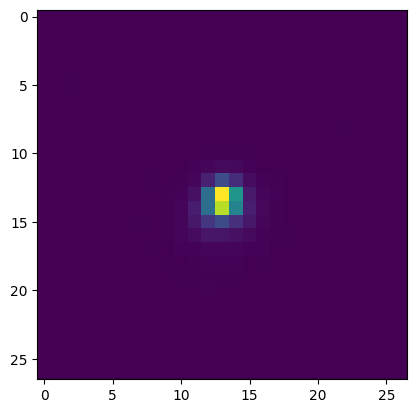

In [70]:
plt.imshow(psf_yx)

### Curve fit

In [71]:
from scipy.optimize import curve_fit

In [72]:
# bg = np.median(psf_yx)
bg = np.median(psf)
amp = psf_yx.max() - bg

In [73]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2
    ]

In [74]:
popt, pcov = curve_fit(
    eval_fun_2d,
    coords_yx,
    psf_yx.ravel(),
    p0=params,
)

In [75]:
popt

array([ 9827.75602013,   112.12514917,  2133.17404318,  2194.30458612,
       17308.21870868, -1043.77974273, 20100.10809753])

In [76]:
from copy import copy
cv_2d_params = copy(popt)

In [77]:
cv_2d = gauss_2d(*popt)(fine_coords_yx)
cv_2d = cv_2d.reshape((500, 500))

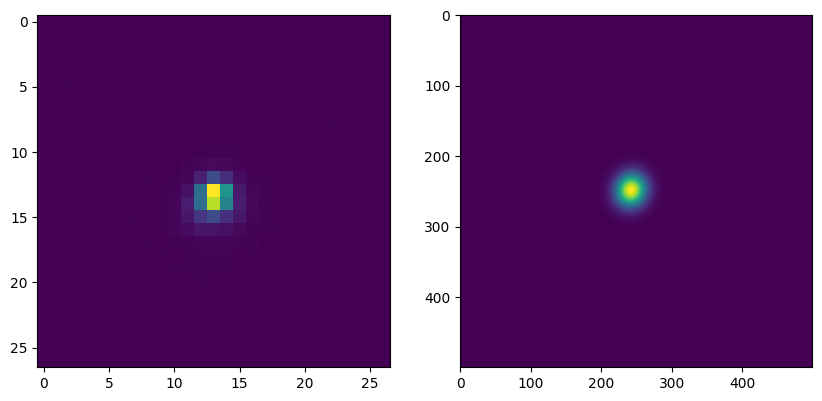

In [78]:
show_2d_fit(psf_yx, cv_2d)

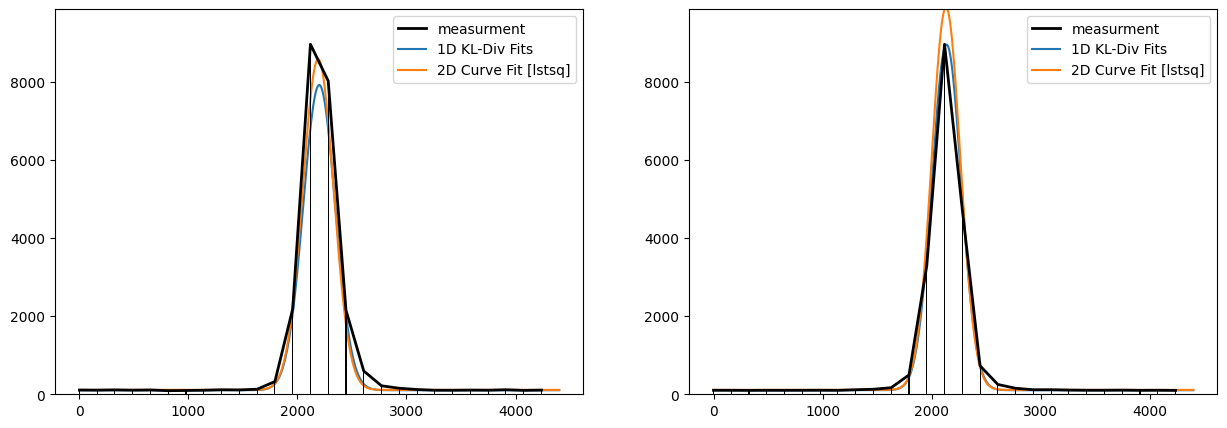

In [79]:
center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=10)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=10)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend()

### Minimize KL-Div

In [80]:
res = compute_KL_div_fit_2d(coords_yx, psf_yx.ravel(), params, spacing)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29576D+04    |proj g|=  1.04000D+02

At iterate    1    f=  8.18099D+03    |proj g|=  1.98565D+01

At iterate    2    f=  4.55840D+03    |proj g|=  9.17367D+00

At iterate    3    f=  4.04172D+03    |proj g|=  4.91460D+00

At iterate    4    f=  4.04069D+03    |proj g|=  4.72879D+00

At iterate    5    f=  4.03038D+03    |proj g|=  4.79550D+00

At iterate    6    f=  4.02852D+03    |proj g|=  2.92480D+00

At iterate    7    f=  4.02841D+03    |proj g|=  4.21108D-01

At iterate    8    f=  4.02840D+03    |proj g|=  5.88125D-01

At iterate    9    f=  4.02837D+03    |proj g|=  1.47656D+00

At iterate   10    f=  4.02830D+03    |proj g|=  2.70466D+00

At iterate   11    f=  4.02816D+03    |proj g|=  3.86972D+00

At iterate   12    f=  4.02794D+03    |proj g|=  4.03634D+00

At iterate   13    f=  4.0

In [81]:
res.x

array([ 7779.65472366,   108.15970749,  2130.92295277,  2213.71742948,
       23772.77497071, -1759.07830899, 26489.37868565])

In [82]:
kl_2d_params = copy(res.x)

In [83]:
kl_2d = gauss_2d(*res.x)(fine_coords_yx)
kl_2d = kl_2d.reshape((500, 500))

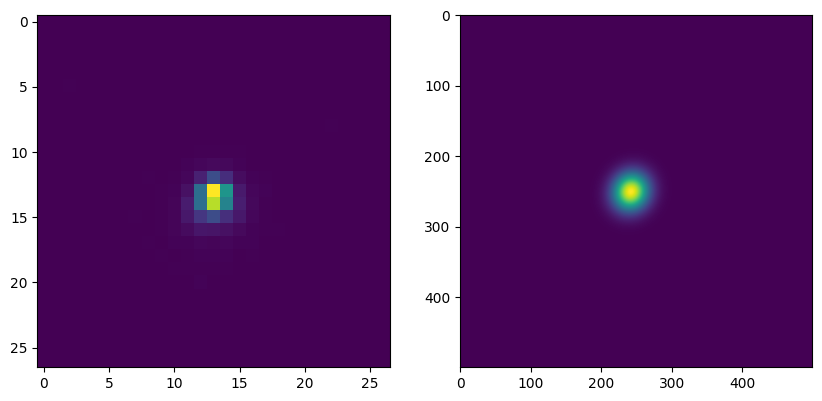

In [84]:
show_2d_fit(psf_yx, kl_2d)

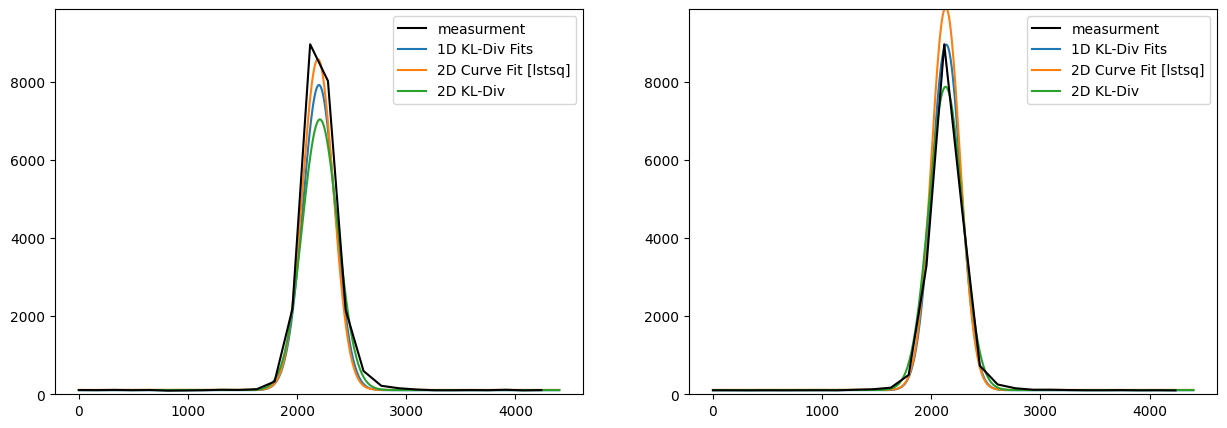

In [85]:
center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=5)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_y[:,0], gauss_2d(*res.x)(fine_coords_y), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=5)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_x[:,1], gauss_2d(*res.x)(fine_coords_x), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();

In [86]:
from skimage.measure import find_contours

In [87]:
cc = find_contours(gauss_2d(*params)(fine_coords_yx).reshape(500, 500), level=amp/2 + bg)[0]
cc = cc / 500 * psf_yx.shape[0]

In [88]:
cv_cc = find_contours(cv_2d, level=popt[0]/2 + popt[1])[0]
cv_cc = cv_cc / 500 * psf_yx.shape[0]

In [89]:
kl_cc = find_contours(kl_2d, level=res.x[0]/2 + res.x[1])[0]
kl_cc = kl_cc / 500 * psf_yx.shape[0]

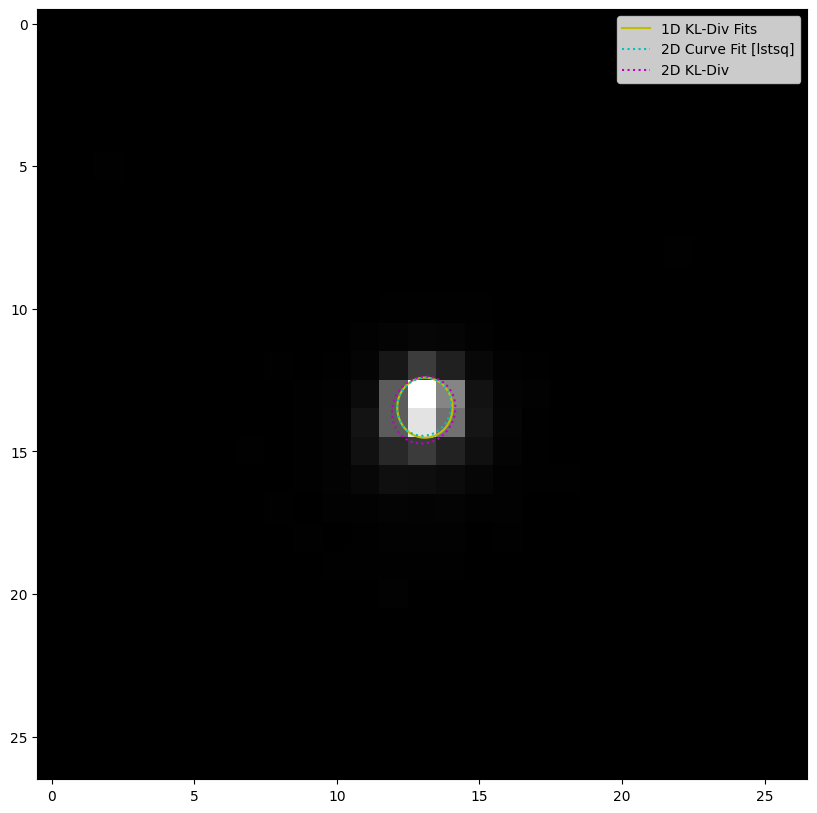

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(psf_yx, cmap='gray')
plt.plot(cc[:,1], cc[:,0], '-', color='y', label="1D KL-Div Fits")
plt.plot(cv_cc[:,1], cv_cc[:,0], ':', color='c', label="2D Curve Fit [lstsq]")
plt.plot(kl_cc[:,1], kl_cc[:,0], ':', color='m', label="2D KL-Div")
plt.legend()

In [91]:
cv_2d_fwhm_x = fwhm(np.sqrt(popt[4]))
cv_2d_fwhm_y = fwhm(np.sqrt(popt[6]))

In [92]:
kld_2d_fwhm_x = fwhm(np.sqrt(res.x[4]))
kld_2d_fwhm_y = fwhm(np.sqrt(res.x[6]))

In [93]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:4.4f}, {est_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_x:4.4f}, {cv_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_x:4.4f}, {cv_2d_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_x:4.4f}, {kld_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_x:4.4f}, {kld_2d_fwhm_x/spacing[2]:4.4f}")

FWHM X
Est. 1D: 363.2114, 2.2283
CV.  1D:  299.1463, 1.8353
CV.  2D:  309.8018, 1.9006
KLD. 1D:  316.4547, 1.9414
KLD. 2D:  363.0761, 2.2275


In [94]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:4.4f}, {est_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_y:4.4f}, {cv_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_y:4.4f}, {cv_2d_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_y:4.4f}, {kld_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_y:4.4f}, {kld_2d_fwhm_y/spacing[1]:4.4f}")

FWHM Y
Est. 1D: 423.1665, 2.5961
CV.  1D:  322.7080, 1.9798
CV.  2D:  333.8543, 2.0482
KLD. 1D:  344.4842, 2.1134
KLD. 2D:  383.2601, 2.3513


# 3D

In [95]:
zz = np.arange(psf.shape[0]) * spacing[0]
yy = np.arange(psf.shape[1]) * spacing[1]
xx = np.arange(psf.shape[2]) * spacing[2]
z, y, x = np.meshgrid(zz, yy, xx, indexing="ij")
coords_zyx = np.stack([z.ravel(), y.ravel(), x.ravel()], -1)

In [96]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

# fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
# fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

### Curve fit

In [97]:
from scipy.optimize import curve_fit

In [98]:
bg = np.median(psf)
amp = psf.max() - bg

In [99]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        mu_z,
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_z/(2 * np.sqrt(2 * np.log(2))))**2,
    ]

In [100]:
popt, pcov = curve_fit(
    eval_fun_3d,
    coords_zyx,
    psf.ravel(),
    p0=params,
)

In [101]:
popt

array([ 7.88240157e+03,  1.17534406e+02,  2.13106871e+03,  2.17188663e+03,
        2.01261481e+03,  2.45784137e+04, -6.93233470e+02, -3.73466602e+03,
        2.82869312e+04,  2.22971081e+02,  2.45198533e+05])

In [102]:
cv_3d = gauss_3d(*popt)(fine_coords_zyx)
cv_3d = cv_3d.reshape((500, 500, 500))

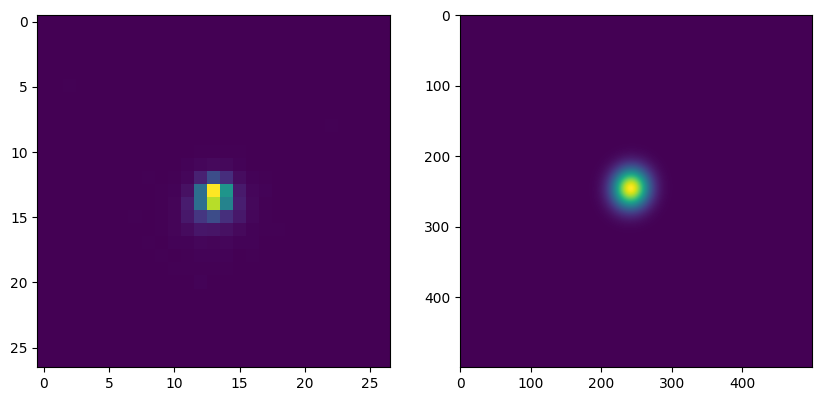

In [103]:
show_2d_fit(psf[psf.shape[0]//2], cv_3d[cv_3d.shape[0]//2])

### Minimize KL-Div

In [104]:
from scipy.special import kl_div
from scipy.optimize import minimize



In [105]:
params

[8859.0,
 104.0,
 2137.726258140569,
 2199.8068061487224,
 2042.1515798059818,
 18059.582697781334,
 0,
 0,
 21400.457015672746,
 0,
 169885.26709973218]

In [106]:
res = compute_KL_div_fit_3d(coords_zyx, psf.ravel(), params, spacing)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39378D+06    |proj g|=  1.35276D+02

At iterate    1    f=  6.13444D+05    |proj g|=  2.27815D+02

At iterate    2    f=  3.05310D+05    |proj g|=  2.51619D+02

At iterate    3    f=  2.38694D+05    |proj g|=  2.56637D+02

At iterate    4    f=  2.34521D+05    |proj g|=  1.93944D+03

At iterate    5    f=  2.30838D+05    |proj g|=  2.50136D+02

At iterate    6    f=  2.26994D+05    |proj g|=  2.41764D+02

At iterate    7    f=  2.16582D+05    |proj g|=  1.31175D+02

At iterate    8    f=  2.14097D+05    |proj g|=  2.54370D+01

At iterate    9    f=  2.13678D+05    |proj g|=  8.75744D+00

At iterate   10    f=  2.13674D+05    |proj g|=  8.68759D+00

At iterate   11    f=  2.13673D+05    |proj g|=  8.64684D+00

At iterate   12    f=  2.13669D+05    |proj g|=  1.47353D+01

At iterate   13    f=  2.1

In [107]:
res.x

array([ 7.56475089e+03,  1.11371751e+02,  2.13042017e+03,  2.18823431e+03,
        2.04432366e+03,  2.70893740e+04, -6.13850324e+02,  3.28181853e+02,
        3.21006855e+04, -1.18923781e+02,  2.54827901e+05])

In [108]:
kl_3d = gauss_3d(*res.x)(fine_coords_zyx)
kl_3d = kl_3d.reshape((500, 500, 500))

In [109]:
cv_3d_fwhm_x = fwhm(np.sqrt(popt[5]))
cv_3d_fwhm_y = fwhm(np.sqrt(popt[8]))
cv_3d_fwhm_z = fwhm(np.sqrt(popt[10]))

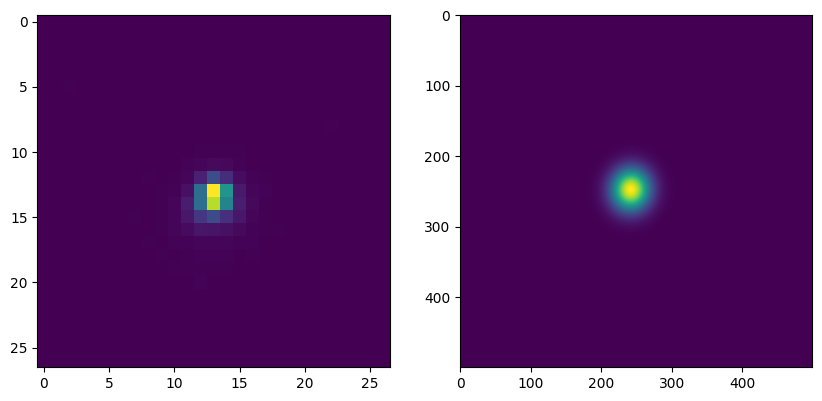

In [110]:
show_2d_fit(psf[psf.shape[0]//2], kl_3d[kl_3d.shape[0]//2])

In [111]:
kld_3d_fwhm_x = fwhm(np.sqrt(res.x[5]))
kld_3d_fwhm_y = fwhm(np.sqrt(res.x[8]))
kld_3d_fwhm_z = fwhm(np.sqrt(res.x[10]))

In [112]:
from skimage.measure import find_contours

In [113]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

In [114]:
fc_z_plane = np.stack([
    (np.ones((1, 500, 500)) * psf.shape[0]//2 * spacing[0]).ravel(),
    y_fine[:1].ravel(),
    x_fine[:1].ravel()
],
-1
)

In [115]:
fc_y_plane = np.stack([
    z_fine[:, :1].ravel(),
    (np.ones((500, 1, 500)) * psf.shape[1]//2 * spacing[1]).ravel(),
    x_fine[:, :1].ravel()
],
-1
)

In [116]:
fc_x_plane = np.stack([
    z_fine[:, :, :1].ravel(),
    y_fine[:, :, :1].ravel(),
    (np.ones((500, 500, 1)) * psf.shape[1]//2 * spacing[2]).ravel(),
],
-1
)

In [117]:
base_z_plane = gauss_3d(*params)(fc_z_plane).reshape(500, 500)
cv_z_plane = gauss_3d(*popt)(fc_z_plane).reshape(500, 500)
kl_z_plane = gauss_3d(*res.x)(fc_z_plane).reshape(500, 500)

In [118]:
base_y_plane = gauss_3d(*params)(fc_y_plane).reshape(500, 500)
cv_y_plane = gauss_3d(*popt)(fc_y_plane).reshape(500, 500)
kl_y_plane = gauss_3d(*res.x)(fc_y_plane).reshape(500, 500)

In [119]:
base_x_plane = gauss_3d(*params)(fc_x_plane).reshape(500, 500)
cv_x_plane = gauss_3d(*popt)(fc_x_plane).reshape(500, 500)
kl_x_plane = gauss_3d(*res.x)(fc_x_plane).reshape(500, 500)

In [120]:
cv2d_z_plane = gauss_2d(*cv_2d_params)(fine_coords_yx).reshape(500, 500)

In [121]:
kl2d_z_plane = gauss_2d(*kl_2d_params)(fine_coords_yx).reshape(500, 500)

In [122]:
base_z_contours = find_contours(base_z_plane, level=params[0]/2 + params[1])[0]
base_z_contours = base_z_contours / 500 * psf.shape[1]

In [123]:
cv2d_z_convtours = find_contours(cv2d_z_plane, level=cv_2d_params[0]/2 + cv_2d_params[1])[0]
cv2d_z_convtours = cv2d_z_convtours / 500 * psf.shape[1]

In [124]:
kl2d_z_convtours = find_contours(kl2d_z_plane, level=kl_2d_params[0]/2 + kl_2d_params[1])[0]
kl2d_z_convtours = kl2d_z_convtours / 500 * psf.shape[1]

In [125]:
base_y_contours = find_contours(base_y_plane, level=params[0]/2 + params[1])[0]
base_y_contours = base_y_contours / 500 * psf.shape[1]

In [126]:
base_x_contours = find_contours(base_x_plane, level=params[0]/2 + params[1])[0]
base_x_contours = base_x_contours / 500 * psf.shape[1]

In [127]:
cv_z_contours = find_contours(cv_z_plane, level=popt[0]/2 + popt[1])[0]
cv_z_contours = cv_z_contours / 500 * psf.shape[1]

In [128]:
cv_y_contours = find_contours(cv_y_plane, level=popt[0]/2 + popt[1])[0]
cv_y_contours = cv_y_contours / 500 * psf.shape[1]

In [129]:
cv_x_contours = find_contours(cv_x_plane, level=popt[0]/2 + popt[1])[0]
cv_x_contours = cv_x_contours / 500 * psf.shape[1]

In [130]:
kl_z_contours = find_contours(kl_z_plane, level=res.x[0]/2 + res.x[1])[0]
kl_z_contours = kl_z_contours / 500 * psf.shape[1]

In [131]:
kl_y_contours = find_contours(kl_y_plane, level=res.x[0]/2 + res.x[1])[0]
kl_y_contours = kl_y_contours / 500 * psf.shape[1]

In [132]:
kl_x_contours = find_contours(kl_x_plane, level=res.x[0]/2 + res.x[1])[0]
kl_x_contours = kl_x_contours / 500 * psf.shape[1]

In [133]:
from matplotlib_scalebar.scalebar import ScaleBar


In [134]:
xy_spacing = spacing[1]
z_spacing = spacing[0]

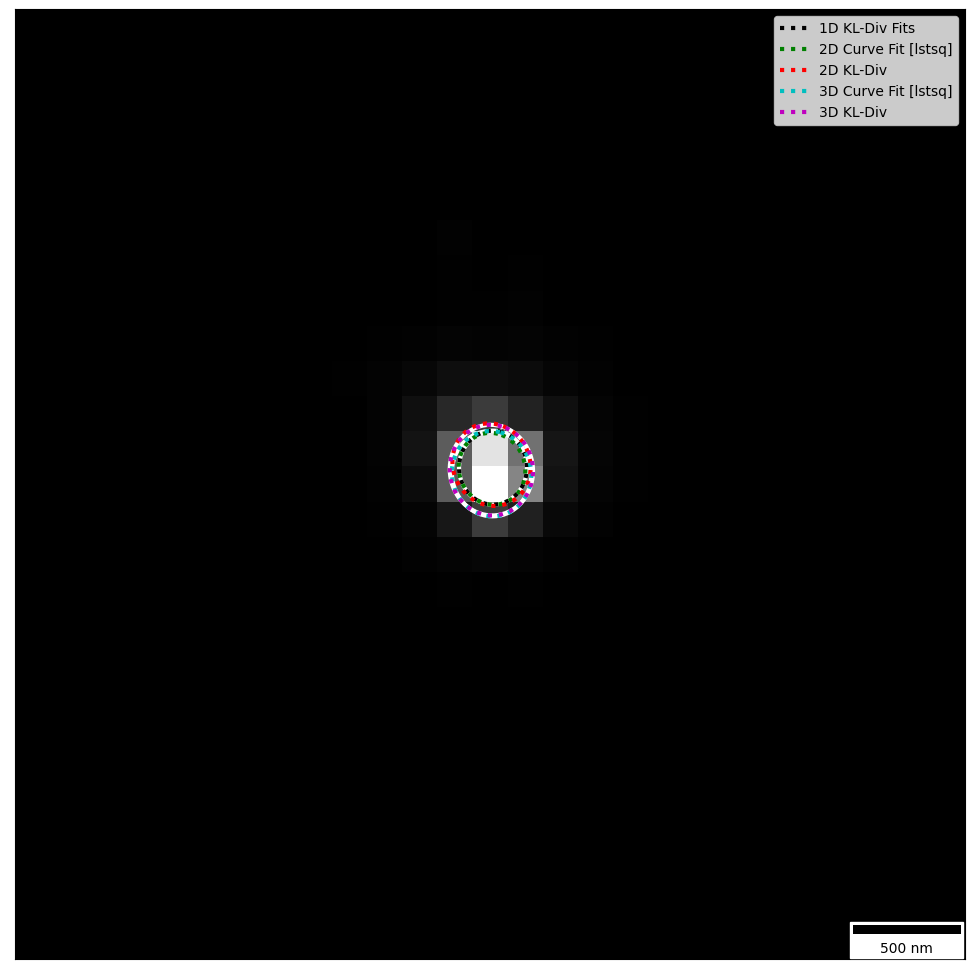

In [135]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]
fig = plt.figure(figsize=(10,10))

ax_xy = fig.add_axes([0.025, 0.025, 0.95, 0.95])

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

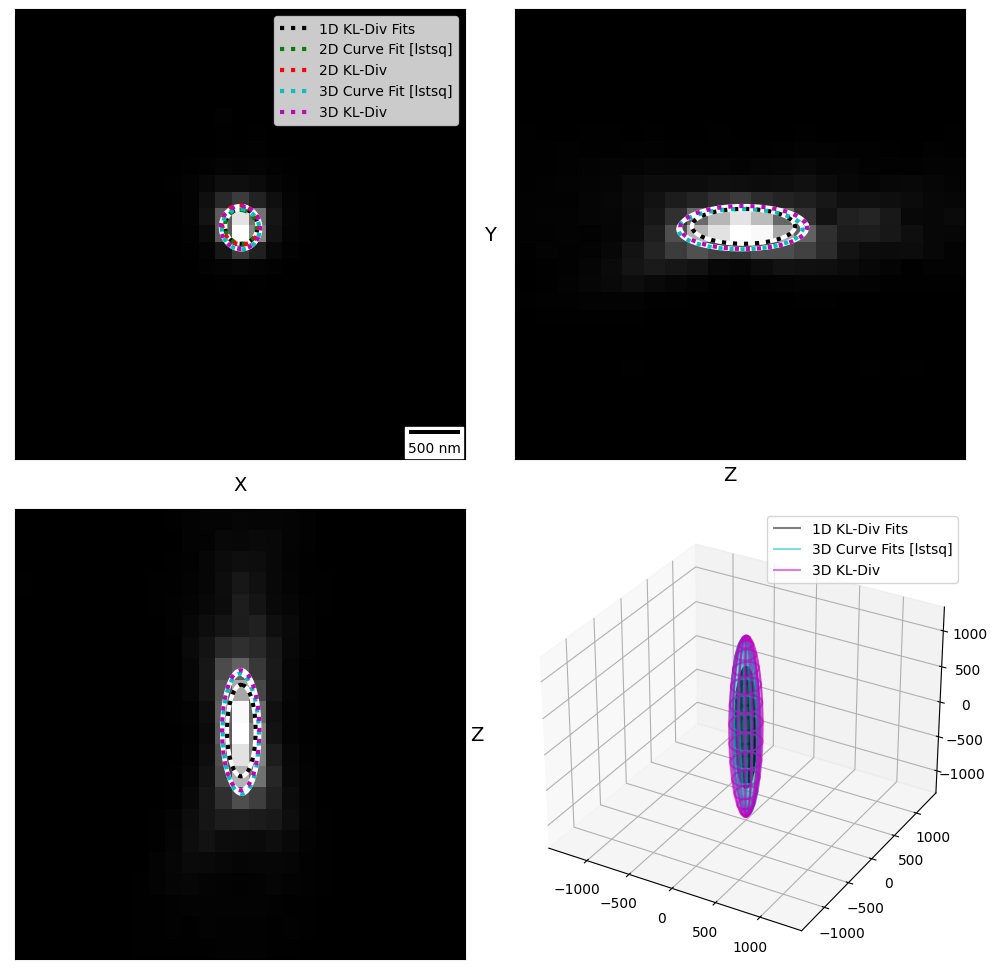

In [136]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    psf[:, psf.shape[1]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    psf[:, :, psf.shape[2]//2].T,
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)


ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing)
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5, label="1D KL-Div Fits")

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing)
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5, label="3D Curve Fits [lstsq]")

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing)
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5, label="3D KL-Div")


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])
ax_3D.legend()

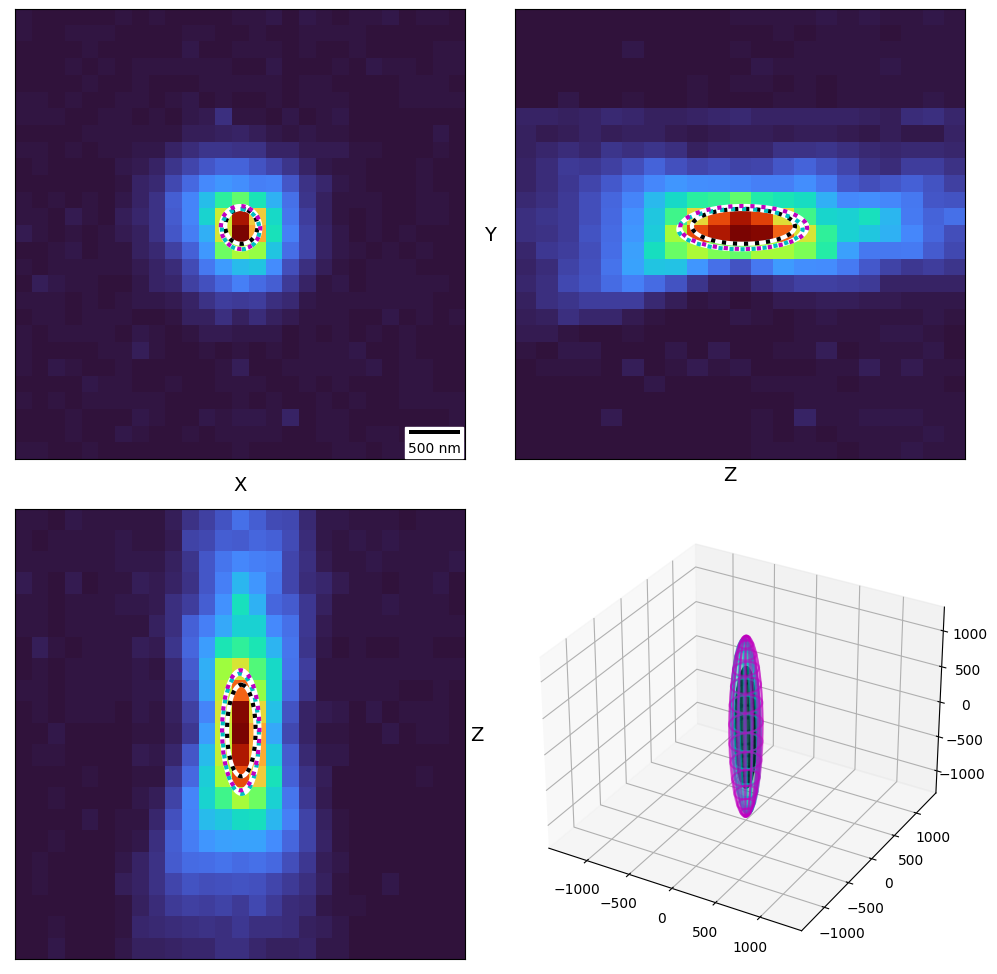

In [137]:
vmin, vmax = np.quantile(np.sqrt(np.max(psf, axis=0)), 0.03), np.quantile(np.sqrt(np.max(psf, axis=0)), 1)

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")


scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    np.sqrt(np.max(psf, axis=0)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3)

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    np.sqrt(np.max(psf, axis=1)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    np.sqrt(np.max(psf, axis=2)).T,
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)

ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing)
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing)
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5)

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing)
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5)


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])

In [138]:
cv_3d_cov = np.array(
    [
        [popt[5], popt[6], popt[7]],
        [popt[6], popt[8], popt[9]],
        [popt[7], popt[9], popt[10]]
    ]
)

In [139]:
kl_3d_cov = np.array(
    [
        [res.x[5], res.x[6], res.x[7]],
        [res.x[6], res.x[8], res.x[9]],
        [res.x[7], res.x[9], res.x[10]]
    ]
)

In [140]:
pc = np.sort(np.sqrt(np.linalg.eigvals(cv_3d_cov)))[::-1]
cv_3d_pa1 = fwhm(pc[0])
cv_3d_pa2 = fwhm(pc[1])
cv_3d_pa3 = fwhm(pc[2])

In [141]:
pc = np.sort(np.sqrt(np.linalg.eigvals(kl_3d_cov)))[::-1]
kl_3d_pa1 = fwhm(pc[0])
kl_3d_pa2 = fwhm(pc[1])
kl_3d_pa3 = fwhm(pc[2])

In [142]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:9.4f}nm, {est_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_x:9.4f}nm, {cv_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_x:9.4f}nm, {cv_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_x:9.4f}nm, {cv_3d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_x:9.4f}nm, {kld_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_x:9.4f}nm, {kld_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_x:9.4f}nm, {kld_3d_fwhm_x/spacing[2]:9.4f}px")

FWHM X
Est. 1D:  363.2114nm,    2.2283px
CV.  1D:  299.1463nm,    1.8353px
CV.  2D:  309.8018nm,    1.9006px
CV.  3D:  369.1770nm,    2.2649px
KLD. 1D:  316.4547nm,    1.9414px
KLD. 2D:  363.0761nm,    2.2275px
KLD. 3D:  387.5763nm,    2.3778px


In [143]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:9.4f}nm, {est_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_y:9.4f}nm, {cv_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_y:9.4f}nm, {cv_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_y:9.4f}nm, {cv_3d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_y:9.4f}nm, {kld_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_y:9.4f}nm, {kld_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_y:9.4f}nm, {kld_3d_fwhm_y/spacing[1]:9.4f}px")

FWHM Y
Est. 1D:  423.1665nm,    2.5961px
CV.  1D:  322.7080nm,    1.9798px
CV.  2D:  333.8543nm,    2.0482px
CV.  3D:  396.0506nm,    2.4298px
KLD. 1D:  344.4842nm,    2.1134px
KLD. 2D:  383.2601nm,    2.3513px
KLD. 3D:  421.9052nm,    2.5884px


In [144]:
print("FWHM Z")
print(f"Est. 1D: {est_fwhm_z:9.4f}nm, {est_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_z:9.4f}nm, {cv_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_z:9.4f}nm, {cv_3d_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_z:9.4f}nm, {kld_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_z:9.4f}nm, {kld_3d_fwhm_z/spacing[1]:9.4f}px")

FWHM Z
Est. 1D: 1261.3663nm,    7.7384px
CV.  1D:  952.8485nm,    5.8457px
CV.  3D: 1166.0486nm,    7.1537px
KLD. 1D:  970.5895nm,    5.9545px
KLD. 3D: 1188.7245nm,    7.2928px


In [145]:
print(f"CV Fit Principle Axes: ({cv_3d_pa1:9.4f}nm, {cv_3d_pa2:9.4f}nm, {cv_3d_pa3:9.4f}nm)")
print(f"KL-Div Principle Axes: ({kl_3d_pa1:9.4f}nm, {kl_3d_pa2:9.4f}nm, {kl_3d_pa3:9.4f}nm)")

CV Fit Principle Axes: (1166.1995nm,  396.9023nm,  367.7831nm)
KL-Div Principle Axes: (1188.7257nm,  422.3911nm,  387.0428nm)
